In [1]:
#Import Statements
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image


In [2]:
#To connect to the drive where the datasets are present
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the three datasets and visualize them
dataset1_path = "/content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/Dataset 1/Colorectal Cancer"
dataset2_path = "/content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/Dataset 2/Prostate Cancer"
dataset3_path = "/content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/Dataset 3/Animal Faces"

#Define basic transform function
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#Load data
dataset1 = torchvision.datasets.ImageFolder(root=dataset1_path, transform = data_transform)
dataset2 = torchvision.datasets.ImageFolder(root=dataset2_path, transform = data_transform)
dataset3 = torchvision.datasets.ImageFolder(root=dataset3_path, transform = data_transform)

#To show dataset info
print(dataset1)
print(dataset2)
print(dataset3)

#To show the different classes in each dataset
dataset1_classes = dataset1.classes
dataset2_classes = dataset2.classes
dataset3_classes = dataset3.classes

print(dataset1_classes)
print(dataset2_classes)
print(dataset3_classes)

Dataset ImageFolder
    Number of datapoints: 6010
    Root location: /content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/Dataset 1/Colorectal Cancer
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 6030
    Root location: /content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/Dataset 2/Prostate Cancer
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 6020
    Root location: /content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/Dataset 3/Animal Faces
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
['MUS', 'NORM', 'STR']


In [4]:
#Function to show the different contents of the datasats
def dataset_show_images(dataset, numImages:int, classes:list, shuffle=True):
  print('Diplaying ', numImages,  ' random images:\n')

  loader = torch.utils.data.DataLoader(dataset, batch_size=numImages, shuffle=shuffle)
  batch = next(iter(loader))
  images, labels = batch
  grid = torchvision.utils.make_grid(images, nrow = int(numImages/2))
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))

  print('The size of each image:')
  print(images[0].shape)
  print('\nThe lowest pixel value in the image tensor: ', torch.min(images[0]))
  print('\nThe highest pixel value in the image tensor: ', torch.max(images[0]))
  print('\nlabels: ', labels)
  print('Legend:')
  print('0 -> ',  str(classes[0]))
  print('1 -> ',  str(classes[1]))
  print('2 -> ',  str(classes[2]))

Diplaying  8  random images:

The size of each image:
torch.Size([3, 224, 224])

The lowest pixel value in the image tensor:  tensor(0.0667)

The highest pixel value in the image tensor:  tensor(1.)

labels:  tensor([1, 0, 2, 0, 2, 2, 1, 0])
Legend:
0 ->  MUS
1 ->  NORM
2 ->  STR


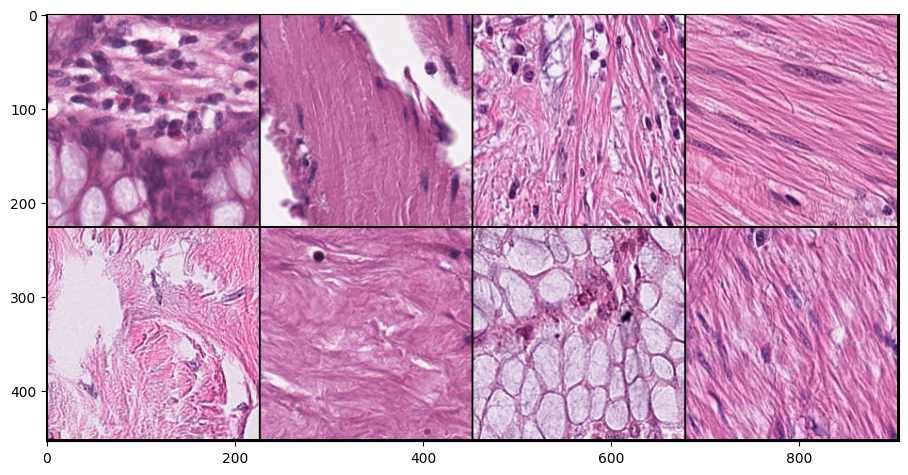

In [5]:
#Displaying Datset 1
dataset_show_images(dataset1, 8, dataset1_classes, True)

Diplaying  8  random images:

The size of each image:
torch.Size([3, 224, 224])

The lowest pixel value in the image tensor:  tensor(0.0314)

The highest pixel value in the image tensor:  tensor(1.)

labels:  tensor([2, 1, 0, 1, 1, 2, 1, 2])
Legend:
0 ->  gland
1 ->  nongland
2 ->  tumor


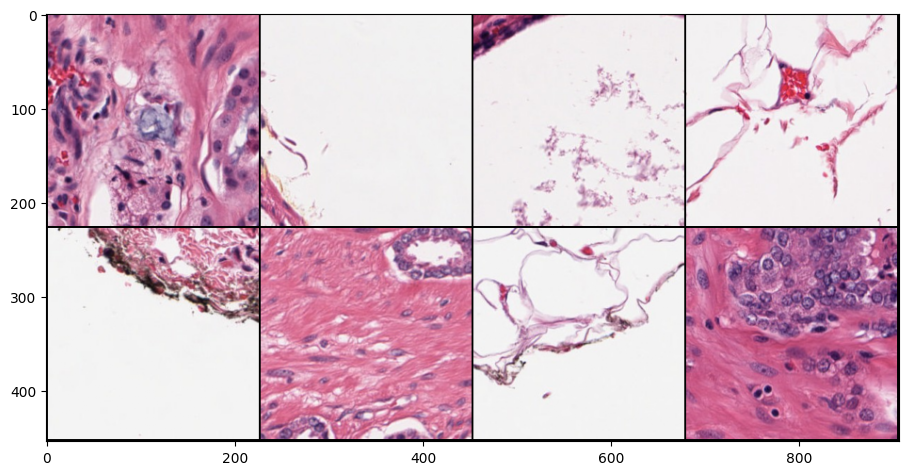

In [6]:
#Displaying Datset 2
dataset_show_images(dataset2, 8, dataset2_classes, True)

Diplaying  8  random images:

The size of each image:
torch.Size([3, 224, 224])

The lowest pixel value in the image tensor:  tensor(0.)

The highest pixel value in the image tensor:  tensor(0.8627)

labels:  tensor([0, 2, 0, 1, 1, 1, 2, 1])
Legend:
0 ->  cat
1 ->  dog
2 ->  wild


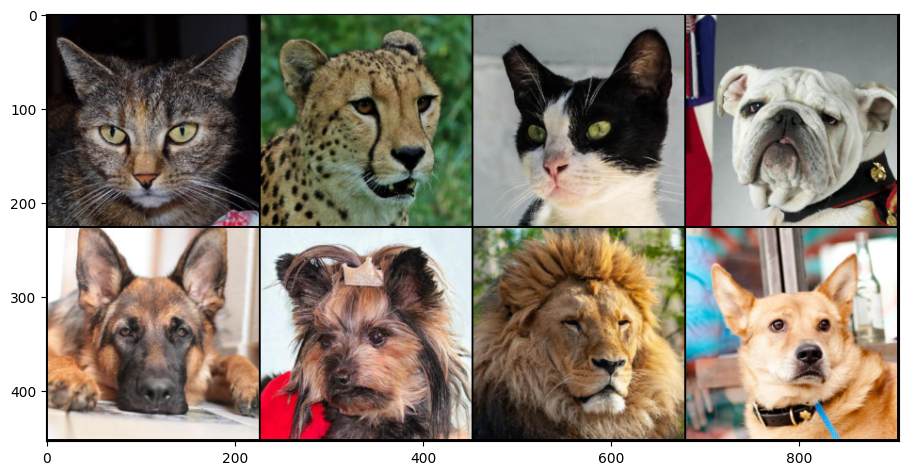

In [7]:
#Displaying Datset 3
dataset_show_images(dataset3, 8, dataset3_classes, True)

In [8]:
#ResNet-18
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer (conv1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer (conv2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


#
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x




In [9]:
#Split into train / test
def get_data(dataset):

    n = len(dataset)  # total number of examples
    n_test = int(0.20 * n)  # take ~20% for test
    for x in range(0, 9):  # rounding it to be divisible by 4
        n_test += 1
        if n_test % 4 == 0:
            break
    train_set, test_set = torch.utils.data.random_split(dataset, [n - n_test, n_test])

    train = DataLoader(train_set, batch_size=32, shuffle=True)
    test = DataLoader(test_set, batch_size= 10, shuffle=False)

    return train, test

In [10]:
print(torch.cuda.is_available())

torch.cuda.empty_cache()


# Getting the data
train, test= get_data(dataset1)
# Instanciating the ResNet18 Class created earlier and Assigning it as our model
model = ResNet18(3)

# The loss function
criterion = nn.CrossEntropyLoss()
#
optimizer = optim.Adam(model.parameters(), lr=0.001)
# momentum=0.9

# Using Cuda cores for the training
model=model.to(torch.device("cuda:0"))


True


train
Epoch 1/20, Loss: 1.1023491621017456
Epoch 1/20, Loss: 1.706315279006958
Epoch 1/20, Loss: 3.472592830657959
Epoch 1/20, Loss: 0.8772727847099304
Epoch 1/20, Loss: 1.0042765140533447
Epoch 1/20, Loss: 1.4056328535079956
Epoch 1/20, Loss: 0.7490699887275696
Epoch 1/20, Loss: 1.0501683950424194
Epoch 1/20, Loss: 0.7053940296173096
Epoch 1/20, Loss: 1.1761281490325928
Epoch 1/20, Loss: 0.5439187288284302
Epoch 1/20, Loss: 0.6697444915771484
Epoch 1/20, Loss: 0.7616735696792603
Epoch 1/20, Loss: 0.558880627155304
Epoch 1/20, Loss: 0.588881254196167
Epoch 1/20, Loss: 0.6080600023269653
Epoch 1/20, Loss: 0.8933956027030945
Epoch 1/20, Loss: 0.9245964884757996
Epoch 1/20, Loss: 0.5474288463592529
Epoch 1/20, Loss: 1.032152533531189
Epoch 1/20, Loss: 0.43344199657440186
Epoch 1/20, Loss: 0.7553394436836243
Epoch 1/20, Loss: 0.6157142519950867
Epoch 1/20, Loss: 0.8411456346511841
Epoch 1/20, Loss: 0.44143471121788025
Epoch 1/20, Loss: 0.4807858467102051
Epoch 1/20, Loss: 0.534352421760559

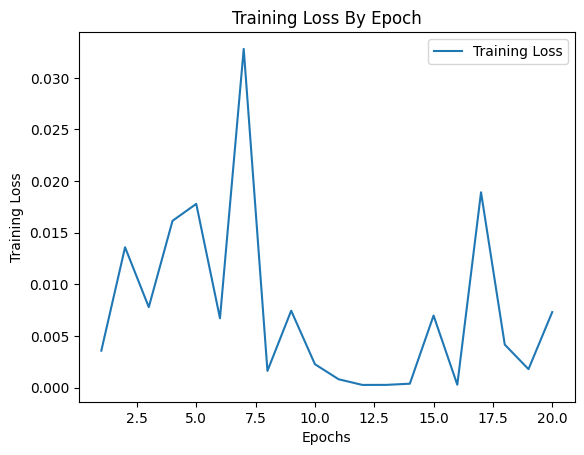

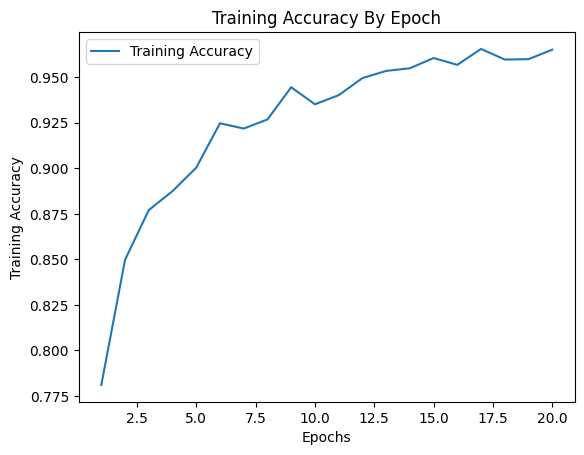

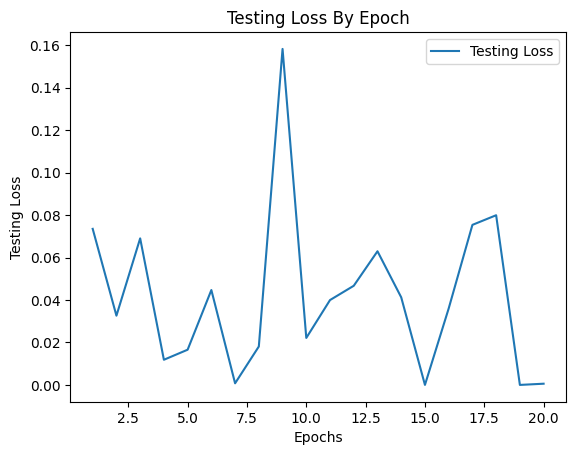

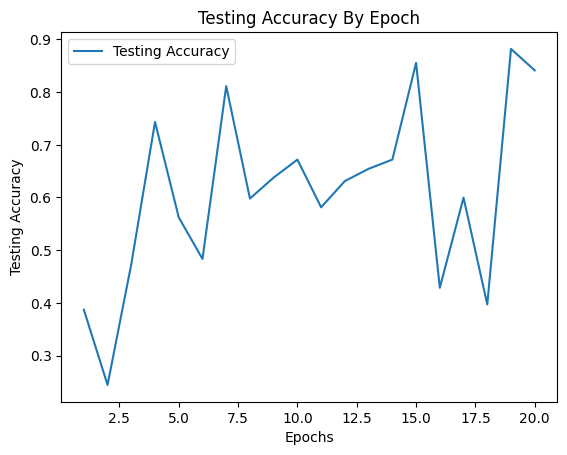

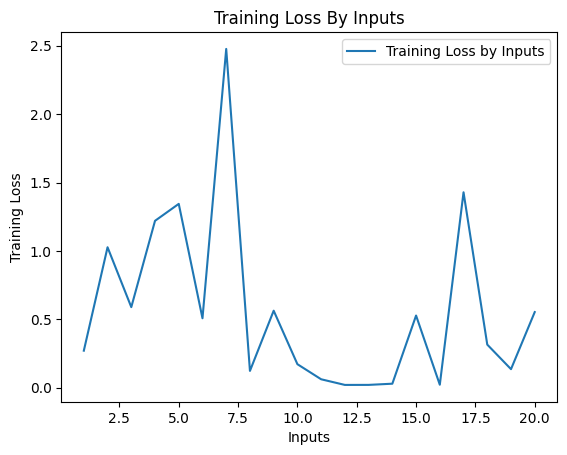

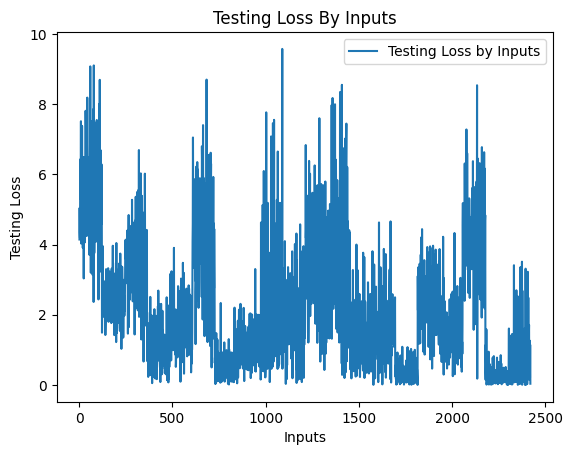

In [13]:
# Training
num_epoch=20
num_epoch_saved=0
lr=0.001
test_size=0


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

running_train_losses = []
running_test_losses = []

#For Saving the model
#'/content/drive/My Drive/Colab Notebooks/Saved models/Latest save'
model_name_to_save = 'model.pth'
save_dir=F"/content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/{model_name_to_save}"
save_dir_opti=F"/content/drive/MyDrive/Comp 432 Project/COMP432-GroupP/optimizer.pth"

print("train")
for epoch in range(num_epoch):
    model.train()
    loss_train= 0.0
    correct = 0
    total = 0
    test_size=0

    if epoch>=1:
      state_dict = torch.load(save_dir)
      state_dict_opti = torch.load(save_dir_opti)
      model.load_state_dict(state_dict)
      optimizer.load_state_dict(state_dict_opti)


    for inputs, labels in train:
      #To Cuda
      inputs=inputs.to(torch.device("cuda:0"))
      labels=labels.to(torch.device("cuda:0"))

      optimizer.zero_grad()
      outputs = model(inputs)
      loss_train = criterion(outputs, labels)
      loss_train.backward()
      optimizer.step()

      #Loss by input Train
      loss_by_input=loss_train.item()
      loss_train += loss_train.item()
      print(f"Epoch {epoch+1}/{num_epoch}, Loss: {loss_by_input}")

      #Accuracy
      total += labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()


    # Checking if the loss has improved this epoch. If so it will save that model,
    # otherwise it will just reload the previous  model and continue from there.
    loss_by_epoch=loss_train / len(train)
    print("This epoch:")
    #print(loss_by_epoch.detach().numpy())
    print(loss_by_epoch.detach().cpu().numpy())

    #epoch<=1
    if (True or (loss_by_epoch.detach().cpu().numpy() <= train_losses[-1])):
     #(loss_by_epoch.detach().numpy() <= train_losses[-1])):
      num_epoch_saved=num_epoch_saved+1
      #Save model
      torch.save(model.state_dict(), save_dir)
      torch.save(optimizer.state_dict(), save_dir_opti)
      print('saved')
      #Loss by batch Train
      #train_losses.append(loss_by_epoch.detach().numpy())
      train_losses.append(loss_by_epoch.detach().cpu().numpy())

      running_train_losses.append(loss_by_input) #New

      #Accuracy by batch Train
      accuracy = correct / total
      train_accuracy.append(accuracy)
      print(f"Epoch {epoch+1}/{num_epoch}, Accuracy: {accuracy}")

      #Test
      model.eval()
      loss_test = 0.0
      correct2 = 0
      total2 = 0

      with torch.no_grad():
        for inputs, labels in test:
          #To Cuda
          inputs=inputs.to(torch.device("cuda:0"))
          labels=labels.to(torch.device("cuda:0"))

          outputs = model(inputs)

          test_size+=1

          #Loss Test
          loss_test = criterion(outputs, labels)
          loss_by_input_test=loss_test.item()#New
          loss_test += loss_test.item()

          running_test_losses.append(loss_by_input_test)#New

          #Accuracy Test
          total2 += labels.size(0)
          _, predicted2 = torch.max(outputs.data, 1)
          correct2 += (predicted2 == labels).sum().item()

        loss_by_epoch2=loss_test / len(test)
        #test_losses.append(loss_by_epoch2.detach().numpy())
        test_losses.append(loss_by_epoch2.detach().cpu().numpy())

        accuracy2 = correct2 / total2
        test_accuracy.append(accuracy2)
        print(test_size)

      print("Test end")

print(num_epoch)
print(len(train_losses))
print(len(test_losses))


#Save model
#torch.save(model.state_dict(), save_dir)
#print('saved')

#del model
torch.cuda.empty_cache()

# Plot Loss Train
plt.plot(range(1, num_epoch_saved+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Epoch')
plt.legend()
plt.show()


# Plot Accuracy Train
plt.plot(range(1, num_epoch_saved+1), train_accuracy , label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy By Epoch')
plt.legend()
plt.show()

# Plot Loss Test
plt.plot(range(1, num_epoch_saved+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Epoch')
plt.legend()
plt.show()

# Plot Accuracy Test
plt.plot(range(1, num_epoch_saved+1), test_accuracy , label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy By Epoch')
plt.legend()
plt.show()


#By input
plt.plot(range(1, len(running_train_losses)+1), running_train_losses, label='Training Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Inputs')
plt.legend()
plt.show()

plt.plot(range(1, len(running_test_losses)+1), running_test_losses, label='Testing Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Inputs')
plt.legend()
plt.show()